In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
import torch
import numpy as np
from matplotlib.patches import FancyArrowPatch
import mlflow
mlflow.set_experiment("neural_ode_2d")
import warnings
warnings.filterwarnings("ignore")

from even_flow.models.neuralode import TimeEmbeddingMLPNeuralODEModel
from even_flow.moons.dataset import MoonsDataset
from even_flow.moons.jobs import MoonsTimeEmbeddinngMLPNeuralODEJob
from even_flow.utils import flatten_dict

/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'default' attribute with value 'min' was provided to the `Field()` function, which has no effect in the context it was used. 'default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/h

# Params

In [2]:
rtols = np.logspace(-2, -7, 2)
atols = np.logspace(-2, -7, 2)
solvers = ['euler', 'dopri5', 'rk4']
neurons = [[16, 2], [16, 16, 2], [16, 16, 16, 2]]
train_samples = 10000
val_samples = 1000
test_samples = 1000
noise = 0.05
batch_size = 32
random_state= 943874

# Dataset

In [3]:
datamodule = MoonsDataset(
    train_samples=train_samples,
    val_samples=val_samples,
    test_samples=test_samples,
    noise=noise,
    batch_size=batch_size,
    random_state=random_state
)

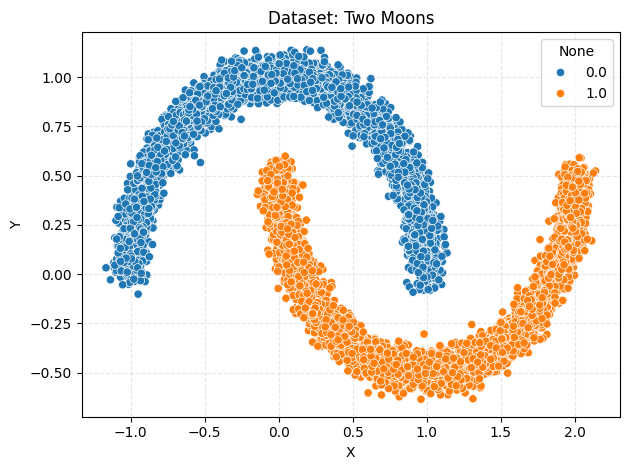

In [4]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.scatterplot(
    x=datamodule.train_X[:, 0].reshape(-1),
    y=datamodule.train_X[:, 1].reshape(-1),
    hue=datamodule.train_y.reshape(-1),
    ax=ax
)
ax.set(
    title='Dataset: Two Moons',
    xlabel='X',
    ylabel='Y'
)
fig.tight_layout()
moons_xlim = ax.get_xlim()
moons_ylim = ax.get_ylim()

# Execution

In [ ]:
jobs = [
    MoonsTimeEmbeddinngMLPNeuralODEJob(
        datamodule=datamodule,
        name=f'time-embedding-mlp-neural-ode-{i}',
        max_epochs=3,
        model=TimeEmbeddingMLPNeuralODEModel(
            input_shape=(2,),
            vector_field=dict(
                input_dims=2,
                time_embed_dims=2,
                time_embed_freq=10,
                neurons_per_layer=neuron_layers,
                activations=['relu']*len(neuron_layers),
            ),
            atol=atol,
            rtol=rtol,
            solver=solver,
            max_epochs=100,
            monitor='val_loss',
            mode='min',
            min_delta=1e-3,
            patience=5,
            verbose=False,
        ),
        
    ) for i, (rtol, atol, solver, neuron_layers) in enumerate(
        product(rtols, atols, solvers, neurons))
]
print(f'Running {len(jobs)} jobs.')

Running 36 jobs.


In [ ]:
for job in jobs:
    print(f'Runnning job: {job.name} | Solver: {job.model.solver} | rtol: {job.model.rtol} | atol: {job.model.atol}')
    job.run()
jobs_df = pd.DataFrame.from_records([
    flatten_dict(job.model_dump())
    for job in jobs
])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-0 | Solver: euler | rtol: 0.01 | atol: 0.01


/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
2025/11/29 15:22:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:23:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:23

Runnning job: time-embedding-mlp-neural-ode-1 | Solver: euler | rtol: 0.01 | atol: 0.01


/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
2025/11/29 15:23:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:23:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:23:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-2 | Solver: euler | rtol: 0.01 | atol: 0.01


2025/11/29 15:23:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:23:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:23:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-3 | Solver: dopri5 | rtol: 0.01 | atol: 0.01


2025/11/29 15:23:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:23:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:23:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-4 | Solver: dopri5 | rtol: 0.01 | atol: 0.01


2025/11/29 15:23:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:23:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:23:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-5 | Solver: dopri5 | rtol: 0.01 | atol: 0.01


2025/11/29 15:24:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:24:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:24:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-6 | Solver: rk4 | rtol: 0.01 | atol: 0.01


2025/11/29 15:24:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:24:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:24:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-7 | Solver: rk4 | rtol: 0.01 | atol: 0.01


2025/11/29 15:24:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:24:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:24:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-8 | Solver: rk4 | rtol: 0.01 | atol: 0.01


2025/11/29 15:24:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:24:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:24:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-9 | Solver: euler | rtol: 0.01 | atol: 1e-07


2025/11/29 15:24:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:25:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:25:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-10 | Solver: euler | rtol: 0.01 | atol: 1e-07


2025/11/29 15:25:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:25:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:25:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-11 | Solver: euler | rtol: 0.01 | atol: 1e-07


2025/11/29 15:25:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:25:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:25:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-12 | Solver: dopri5 | rtol: 0.01 | atol: 1e-07


2025/11/29 15:26:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:26:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:26:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-13 | Solver: dopri5 | rtol: 0.01 | atol: 1e-07


2025/11/29 15:26:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:26:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:26:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-14 | Solver: dopri5 | rtol: 0.01 | atol: 1e-07


2025/11/29 15:27:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:27:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:27:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-15 | Solver: rk4 | rtol: 0.01 | atol: 1e-07


2025/11/29 15:27:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:27:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:27:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-16 | Solver: rk4 | rtol: 0.01 | atol: 1e-07


2025/11/29 15:27:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:27:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:27:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-17 | Solver: rk4 | rtol: 0.01 | atol: 1e-07


2025/11/29 15:28:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:28:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:28:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-18 | Solver: euler | rtol: 1e-07 | atol: 0.01


2025/11/29 15:28:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:28:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:28:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-19 | Solver: euler | rtol: 1e-07 | atol: 0.01


2025/11/29 15:28:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:28:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-20 | Solver: euler | rtol: 1e-07 | atol: 0.01


2025/11/29 15:28:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:28:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:28:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-21 | Solver: dopri5 | rtol: 1e-07 | atol: 0.01


2025/11/29 15:28:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:28:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:28:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-22 | Solver: dopri5 | rtol: 1e-07 | atol: 0.01


2025/11/29 15:29:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:29:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:29:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-23 | Solver: dopri5 | rtol: 1e-07 | atol: 0.01


2025/11/29 15:30:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:30:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:30:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-24 | Solver: rk4 | rtol: 1e-07 | atol: 0.01


2025/11/29 15:30:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:30:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:30:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-25 | Solver: rk4 | rtol: 1e-07 | atol: 0.01


2025/11/29 15:30:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:30:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:30:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-26 | Solver: rk4 | rtol: 1e-07 | atol: 0.01


2025/11/29 15:30:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:30:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:30:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-27 | Solver: euler | rtol: 1e-07 | atol: 1e-07


2025/11/29 15:30:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:31:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:31:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-28 | Solver: euler | rtol: 1e-07 | atol: 1e-07


2025/11/29 15:31:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:31:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:31:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-29 | Solver: euler | rtol: 1e-07 | atol: 1e-07


2025/11/29 15:31:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:31:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:31:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-30 | Solver: dopri5 | rtol: 1e-07 | atol: 1e-07


2025/11/29 15:31:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:31:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:31:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-31 | Solver: dopri5 | rtol: 1e-07 | atol: 1e-07


2025/11/29 15:35:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:35:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:35:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-32 | Solver: dopri5 | rtol: 1e-07 | atol: 1e-07


2025/11/29 15:38:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:38:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:38:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-33 | Solver: rk4 | rtol: 1e-07 | atol: 1e-07


2025/11/29 15:38:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:38:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:38:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-34 | Solver: rk4 | rtol: 1e-07 | atol: 1e-07


2025/11/29 15:38:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:38:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:38:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Runnning job: time-embedding-mlp-neural-ode-35 | Solver: rk4 | rtol: 1e-07 | atol: 1e-07


2025/11/29 15:38:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 15:38:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 15:38:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


,id_,name,model.accelerator,model.profiler,model.max_epochs,model.verbose,model.num_sanity_val_steps,model.checkpoint.dirpath,model.checkpoint.monitor,model.checkpoint.mode,...,metrics.train.loss,metrics.train.nfe,metrics.val.loss,metrics.val.nfe,metrics.test.loss,metrics.test.nfe,model.vector_field.neurons_per_layer.2,model.vector_field.activations.2,model.vector_field.neurons_per_layer.3,model.vector_field.activations.3
0,8695cc4336944975a32e3da8c1c3527e,time-embedding-mlp-neural-ode-0,cpu,simple,100,False,5,None,val_loss,min,...,2.477080,313,2.470523,32,2.476358,32,NaN,NaN,NaN,NaN
1,ae8a7923638142a1866401cb6adb7841,time-embedding-mlp-neural-ode-1,cpu,simple,100,False,5,None,val_loss,min,...,2.494675,313,2.488887,32,2.493006,32,2.0,relu,NaN,NaN
2,60cf090f248044088435567a63c86c68,time-embedding-mlp-neural-ode-2,cpu,simple,100,False,5,None,val_loss,min,...,2.434544,313,2.428944,32,2.434515,32,16.0,relu,2.0,relu
3,a4b1ad4a5e054189b527e1ec63218f8e,time-embedding-mlp-neural-ode-3,cpu,simple,100,False,5,None,val_loss,min,...,2.432031,6260,2.425895,640,2.430290,640,NaN,NaN,NaN,NaN
4,d606ebe020424cbca6ac17817cd46c3a,time-embedding-mlp-neural-ode-4,cpu,simple,100,False,5,None,val_loss,min,...,2.432022,6290,2.425882,652,2.430278,640,2.0,relu,NaN,NaN


In [8]:
jobs_df.head()

,id_,name,model.accelerator,model.profiler,model.max_epochs,model.verbose,model.num_sanity_val_steps,model.checkpoint.dirpath,model.checkpoint.monitor,model.checkpoint.mode,...,metrics.train.loss,metrics.train.nfe,metrics.val.loss,metrics.val.nfe,metrics.test.loss,metrics.test.nfe,model.vector_field.neurons_per_layer.2,model.vector_field.activations.2,model.vector_field.neurons_per_layer.3,model.vector_field.activations.3
0,8695cc4336944975a32e3da8c1c3527e,time-embedding-mlp-neural-ode-0,cpu,simple,100,False,5,None,val_loss,min,...,2.477080,313,2.470523,32,2.476358,32,NaN,NaN,NaN,NaN
1,ae8a7923638142a1866401cb6adb7841,time-embedding-mlp-neural-ode-1,cpu,simple,100,False,5,None,val_loss,min,...,2.494675,313,2.488887,32,2.493006,32,2.0,relu,NaN,NaN
2,60cf090f248044088435567a63c86c68,time-embedding-mlp-neural-ode-2,cpu,simple,100,False,5,None,val_loss,min,...,2.434544,313,2.428944,32,2.434515,32,16.0,relu,2.0,relu
3,a4b1ad4a5e054189b527e1ec63218f8e,time-embedding-mlp-neural-ode-3,cpu,simple,100,False,5,None,val_loss,min,...,2.432031,6260,2.425895,640,2.430290,640,NaN,NaN,NaN,NaN
4,d606ebe020424cbca6ac17817cd46c3a,time-embedding-mlp-neural-ode-4,cpu,simple,100,False,5,None,val_loss,min,...,2.432022,6290,2.425882,652,2.430278,640,2.0,relu,NaN,NaN


# Analysis

In [7]:
job_number = 11
fig = jobs[job_number].quiver_plot()
fig.show()

AttributeError: 'MoonsTimeEmbeddinngMLPNeuralODEJob' object has no attribute 'quiver_plot'

In [19]:
job_number = 10
job = jobs[job_number]
time = np.linspace(0., 1., num=100, dtype='float32')
trajectory = jobs[job_number].model.trajectory(datamodule.train_X,
                                               integration_times=torch.from_numpy(time))
trajectory = trajectory.squeeze(1)
trajectory = trajectory.detach().numpy()
num_arrows = 6
arrow_indices = np.linspace(0, trajectory.shape[0]-2, num=num_arrows, dtype='int')

fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
scatter = ax.scatter(trajectory[:, 0], trajectory[:, 1],
           s=np.full(trajectory.shape[0], 15),
           c=time,
           cmap='viridis',
           label=(f'Starting point: ({datamodule.train_X[0, 0]:.2f}, {datamodule.train_X[0, 1]:.2f})'))
plt.colorbar(scatter, ax=ax, label='Time')
for i in arrow_indices:
    if i == trajectory.shape[0] - 1:
        continue
    x = trajectory[i, 0]
    y = trajectory[i, 1]
    dx = trajectory[i+1, 0] - trajectory[i, 0]
    dy = trajectory[i+1, 1] - trajectory[i, 1]
    arrow = FancyArrowPatch((x, y),
                        (x + dx, y + dy),
                        arrowstyle='->',
                        mutation_scale=20,
                        color='k',
                        alpha=0.5,
                        linewidth=2)
    ax.add_patch(arrow)
ax.legend()
ax.set_title(
    'Neural ODE Trajectory on Two Moons Dataset',
    fontsize='large'
)
ax.set_xlabel('X', fontsize='medium')
ax.set_ylabel('Y', fontsize='medium')
# ax.set_ylim(0.993625, 0.993650)
fig.tight_layout()

AttributeError: 'TimeEmbeddingMLPNeuralODEModel' object has no attribute 'trajectory'

## Relative tolerance X NFE

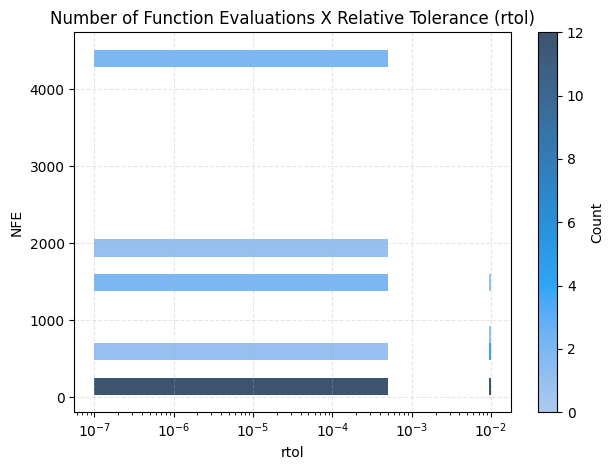

In [14]:
nfes = [
    job.metrics['test']['nfe']
    for job in jobs
]
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    jobs_df,
    x='model.rtol',
    y='metrics.test.nfe',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Number of Function Evaluations X Relative Tolerance (rtol)',
    fontsize='large'
)
ax.set_xlabel('rtol', fontsize='medium')
ax.set_ylabel('NFE', fontsize='medium')
ax.set_xscale('log')
fig.tight_layout()

## Absolute Tolerance x NFE

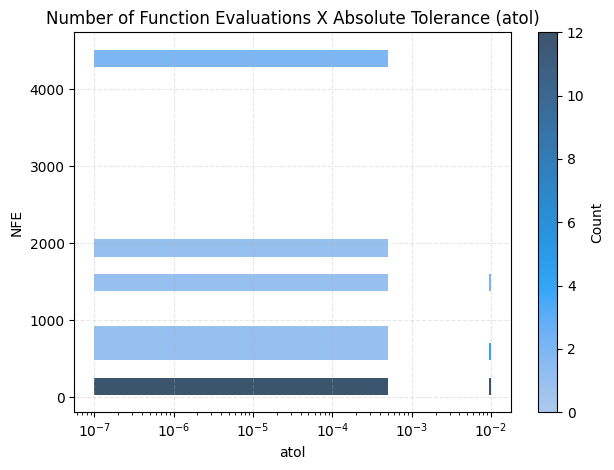

In [15]:
nfes = [
    job.metrics['test']['nfe']
    for job in jobs
]
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    jobs_df,
    x='model.atol',
    y='metrics.test.nfe',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Number of Function Evaluations X Absolute Tolerance (atol)',
    fontsize='large'
)
ax.set_xlabel('atol', fontsize='medium')
ax.set_ylabel('NFE', fontsize='medium')
ax.set_xscale('log')
fig.tight_layout()

## Solver x NFE

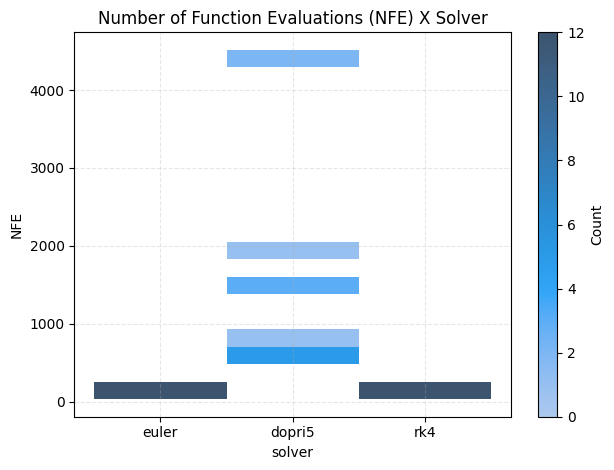

In [18]:
nfes = [
    job.metrics['test']['nfe']
    for job in jobs
]
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    jobs_df,
    x='model.solver',
    y='metrics.test.nfe',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Number of Function Evaluations (NFE) X Solver',
    fontsize='large'
)
ax.set_xlabel('solver', fontsize='medium')
ax.set_ylabel('NFE', fontsize='medium')
fig.tight_layout()